In [1]:
from IPython import display
import binascii
import os

def hide_code_in_slideshow():
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

# Real or Not? NLP with Disaster Tweets
Christopher Akiki, Karl-Heinz Fiebig, Julian Duwe

Supervized by Christian Kahmann

## Overview

* Introduction: Task and Data
* Frameworks: cookiecutter hierarchy + docker + makefile + jupyter + tensorflow + scikitlearn + others
* Exploratory Data Analysis
* Preprocessing and Basic Approaches
* Metafeatures - KH
* Representation Learning / Topic Modeling / Sentiment Analysis - Chris
* Outlook: Ensemble Learning (Stacking) etc.

* We used bla

* We won all of Kaggle
![](https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png)

# PreProcessing and Basic Approaches

## starting Point kaggle-Tutorial

* uses CountVectorizer
    * Tf score
    * has inbuilt preprocessing steps    
    
    
## How to improve?

 * more and individual Preprocessing
     * removing Stopwords
     * ignoring least and most frequent words
     * limiting Vocabulary
 
     * implementing additional Features for Lemmatizing
     
 * different Classifiers

| method | submission score |
| :- | --- |
|Tutorial| 0.79160 |
|Tf score with linear SVM, removing Stopwords and Lemmatize | 0.78761 |
|Tf score with Naive Bayes| 0.79344 |
|Tf score with Naive Byes, removing Stopwords and Lemmatize| 0.78853 |
|Tfidf score with Naive Bayes | 0.78577 |
|Tfidf score with Naive Bayes, removing Stopwords and Lemmatize| 0.79037
|Tfidf score with Linear SVC | 0.77045 |
|Tfidf score with Linear SVC, removing Stopwords and Lemmatize | 0.79068 |

   * In general there is no real improvement to the score of the tutorial


   * the more preprocessing, the more discrepancy of Train and TestData 

        --> Model is too strong
 
### need for other solutions or approaches

# Meta-Level Features
* Tweet Statistics
* Linguistic Tags
* Named Entities
* Acronyms & Emojis
* Word Emphasis & Punctuation
* Sentiment Scores

Detailed descriptions & Code at:
https://nbviewer.jupyter.org/github/cakiki/disaster-tweets/blob/main/notebooks/meta_feature_exploration.ipynb

In [3]:
# Run some preprocessing used throughout the rest of the sections

!pip install textblob vaderSentiment afinn

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_extraction, feature_selection
from features import meta_features_spacy as mf

# The training data file
train_data_file = '../data/external/kaggle/train.csv'
# Load data and perform some sanity checks
print('Loading training data from {}...'.format(train_data_file))
df = pd.read_csv(train_data_file)
X = df[['keyword', 'location', 'text']].values
y = df['target'].values
print('-> Done')

# Perform basic preprocessing of the data and convert to a spacy featuer set
sp = spacy.load('en_core_web_sm')
def preproc(x):
    txt = " ".join([str(x[i]) for i in range(0, 3) if str(x[i]) != "nan"])
    return sp(txt)
print("Converting tweets to spacy docs...")
X_sp = np.array([preproc(x) for x in X], dtype=object)
print("-> Done.")

# Define some functions that will be used throughout the slides
# Bar plot function to visualise the tag distributions
def plot_count_vec_bars(X_sp, transformer, title, exclude=[]):  
    transformer.fit(X_sp)
    labels = transformer.get_feature_names()
    
    # Compute counts
    count = transformer.transform(X_sp).toarray()
    # Remove blacklisted tags from column
    for exc_tag in exclude:
        del_idx = labels.index(exc_tag.lower())
        labels = np.delete(labels, del_idx)
        count = np.delete(count, del_idx, 1)
        
    # Compute support: how many of the tweets have non zero rows out of all tweets
    support = np.sum(np.sum(count, axis=1) > 0) / float(len(y))

    # Split counts into classes
    count_c0 = count[y==0]
    count_c1 = count[y==1]
    s0 = count_c0.sum(axis=0)
    s1 = count_c1.sum(axis=0)

    # Sort by class 0 counts
    sorted_idx = np.argsort(s0)[::-1]
    s0 = s0[sorted_idx]
    s1 = s1[sorted_idx]
    labels = np.array(labels)[sorted_idx]

    plt.title('{} (Support: {}%)'.format(title, round(support*100, 1)))
    plt.bar(np.arange(len(labels)), s0/float(s0.sum()), fc=(0, 0, 1, 0.5), label="Class 0")
    plt.bar(np.arange(len(labels)), s1/float(s1.sum()), fc=(1, 0, 0, 0.5), label="Class 1")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.legend()
    plt.xlabel("Tag")

     |████████████████████████████████| 636 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 75 kB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 1.8 MB/s eta 0:00:01
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53450 sha256=f6e6cc2878e7b230015611a3c8b6e563b89e29964f3cacd1708a309af4d61099
  Stored in directory: /home/jovyan/.cache/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434674 sha256=4596c0608f452b002d0f479e849fdd78e0f5af560c449357a0b7f5b72ee718eb
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built afinn nltk
Loading training data from ../data/external/kaggle/train.csv...
-> Done
Converting tweets to spacy docs...
-> D

## Features based on Tweet Statistics

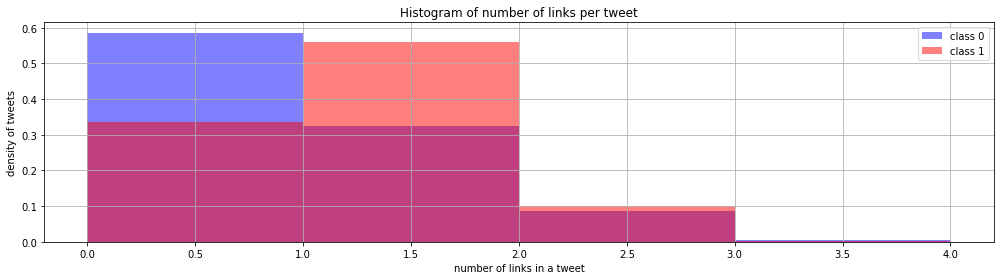

In [4]:
hide_code_in_slideshow()

# Plot link counters
trans = mf.LinkCounter()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()
# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of number of links per tweet')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('number of links in a tweet')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()


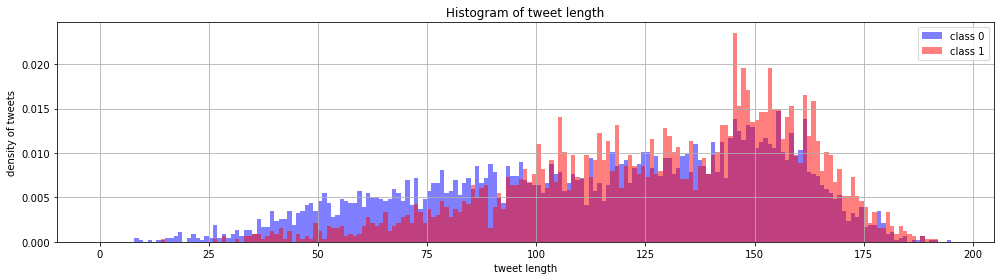

In [5]:
hide_code_in_slideshow()

# Count number of links in each tweet
trans = mf.TextLength()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()

# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of tweet length')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('tweet length')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()

## Features based on Linguistic Tags

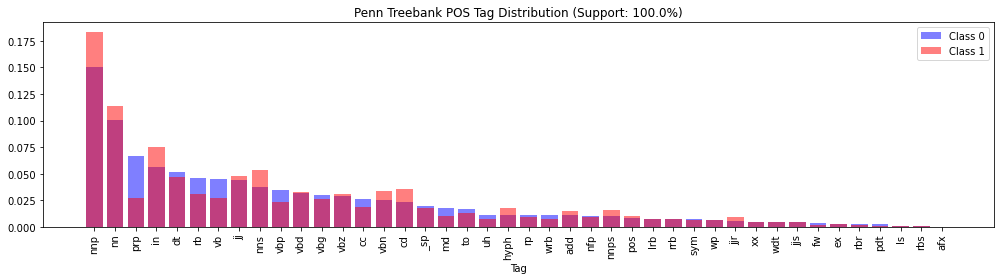

In [6]:
hide_code_in_slideshow()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, mf.PosTagCountVectorizer('penn_treebank'), 'Penn Treebank POS Tag Distribution')
plt.tight_layout()

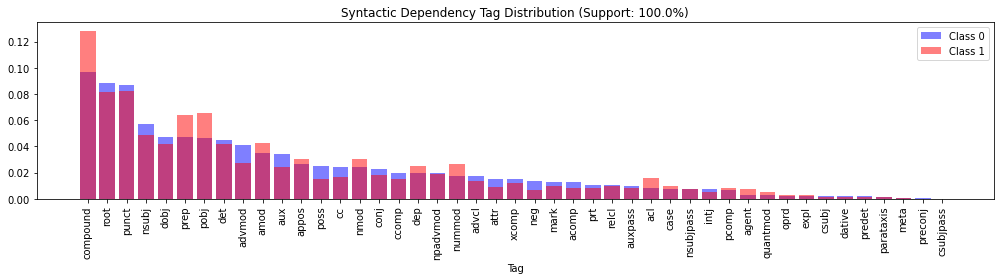

In [7]:
hide_code_in_slideshow()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, mf.DependencyTagCountVectorizer(), 'Syntactic Dependency Tag Distribution')
plt.tight_layout()

## Acronyms & Emojis

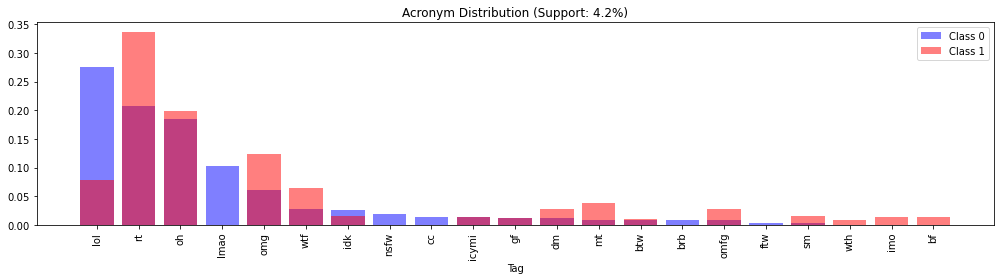

In [8]:
hide_code_in_slideshow()

acro_vectorizer = mf.AcronymCountVectorizer()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, acro_vectorizer, 'Acronym Distribution', exclude=['NO_ACRONYM'])
plt.tight_layout()

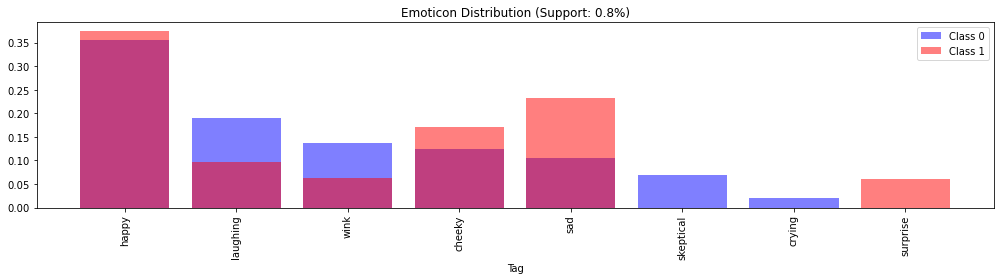

In [9]:
hide_code_in_slideshow()

emoji_vectorizer = mf.EmojiCountVectorizer()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, emoji_vectorizer, 'Emoticon Distribution', exclude=['NO_EMOTICON'])
plt.tight_layout()

## Why are there "Happy" tags?
Some Tweets labaled to be "about disasters" which contain happy, cheecky and laughing tags:
* **[CHEEKY]** @KlaraJoelsson Well I have seen it now! That's a bummer. We've had this heat wave tho... 43'c!! I'd prefer the rain... :P
* **[HAPPY]** @Ashayo @MsMiggi Hi Ashayo! I believe there will be VODs on YouTube after the presentation but there is nothing like seeing it live :)
* **[HAPPY]** @Raishimi33 :) well I think that sounds like a fine plan where little derailment is possible so I applaud you :)
* **[LOL]** @itss_selenaluna like a beautiful ass tragedy lol
* **[LOL]** @lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol


## How do missclassified Tweets look like?

that horrible sinking feeling when you've been at home on your phone for a while and you realise its been on 3G this whole time
**[Predicted: 0; True: 1]**

Keep shape your shoes ??#Amazon #foot #adjust #shape #shoe Mini Shoe Tree Stretcher Shaper Width Extender Adjustable
**[Predicted: 0; True: 1]**

@FoxNewsInsider All Obama is doing is giving a false time schedule on Iran testing there first bomb Bomb = Nuclear Suicide Vest
**[Predicted: 1; True: 0]**

I feel like a tornado http://t.co/iZJK6kpWiZ
**[Predicted: 0; True: 1]**

Ready to get annihilated for the BUCS game
**[Predicted: 0; True: 1]**

## Sentiment Features (Polarity)

In [10]:
# Compute textblob scores
transformer = mf.TextBlobSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)
pol_c0_tb = X_trans[y==0, 0]
pol_c1_tb = X_trans[y==1, 0]
subj_c0_tb = X_trans[y==0, 1]
subj_c1_tb = X_trans[y==1, 1]

# Compute Vader scores
transformer = mf.VaderSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)
pol_c0_vader = X_trans[y==0, 0]
pol_c1_vader = X_trans[y==1, 0]
subj_c0_vader = X_trans[y==0, 3]
subj_c1_vader = X_trans[y==1, 3]

# Compute Afinn scores
transformer = mf.AfinnSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)
pol_c0_afinn = X_trans[y==0, 0]
pol_c1_afinn = X_trans[y==1, 0]


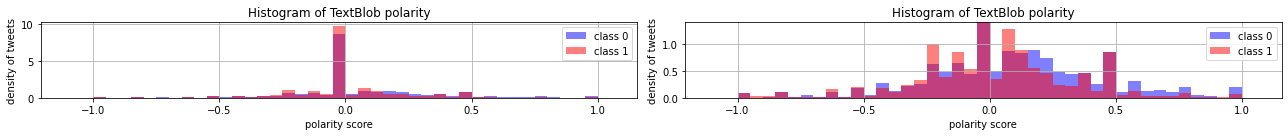

In [11]:
hide_code_in_slideshow()
plt.figure(figsize=(18, 2))

# Plot histograms of polarities
plt.subplot2grid((1, 2), (0, 0))
bins = np.arange(-1.1, 1.1, 0.05)
# TextBlob histogram
plt.title('Histogram of TextBlob polarity')
n, _, _ = plt.hist(pol_c0_tb, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_tb, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.subplot2grid((1, 2), (0, 1))
plt.title('Histogram of TextBlob polarity')
n, _, _ = plt.hist(pol_c0_tb, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_tb, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
plt.ylim([0, 1.4])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

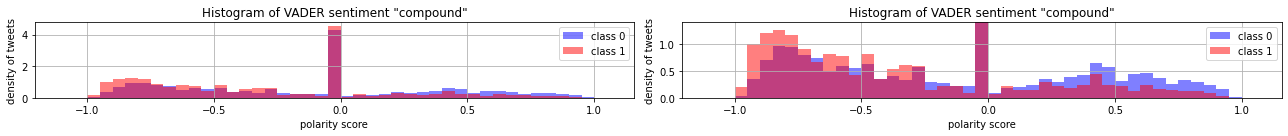

In [12]:
hide_code_in_slideshow()
plt.figure(figsize=(18, 2))

# Vader histogram
plt.subplot2grid((1, 2), (0, 0))
bins = np.arange(-1.1, 1.1, 0.05)
plt.title('Histogram of VADER sentiment "compound"')
n, _, _ = plt.hist(pol_c0_vader, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_vader, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.subplot2grid((1, 2), (0, 1))
bins = np.arange(-1.1, 1.1, 0.05)
plt.title('Histogram of VADER sentiment "compound"')
n, _, _ = plt.hist(pol_c0_vader, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_vader, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
plt.ylim([0, 1.4])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

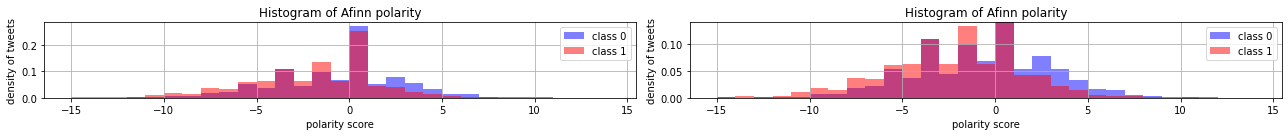

In [13]:
hide_code_in_slideshow()
plt.figure(figsize=(18, 2))

# Afinn histogram
plt.subplot2grid((1, 2), (0, 0))
bins = np.arange(-15, 15, 1)
plt.title('Histogram of Afinn polarity')
n, _, _ = plt.hist(pol_c0_afinn, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_afinn, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
#plt.ylim([0, 1.5])
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.subplot2grid((1, 2), (0, 1))
bins = np.arange(-15, 15, 1)
plt.title('Histogram of Afinn polarity')
n, _, _ = plt.hist(pol_c0_afinn, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1_afinn, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
plt.ylim([0, 0.14])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

## Sentiment Features (Subjectivity)

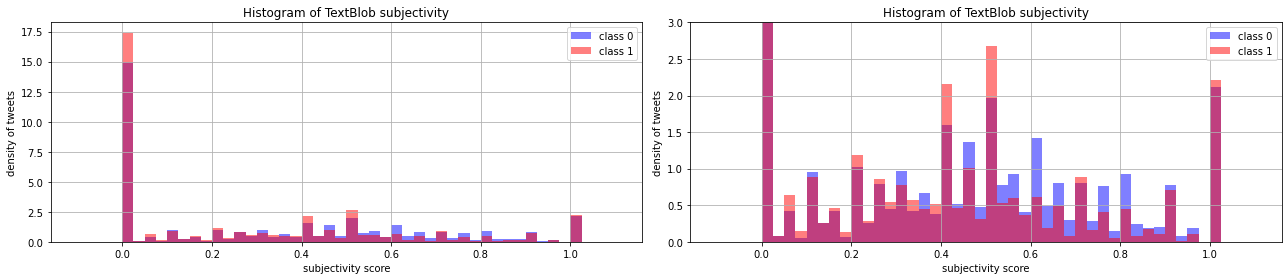

In [14]:
hide_code_in_slideshow()
plt.figure(figsize=(18, 4))

# Plot histograms of polarities
plt.subplot2grid((1, 2), (0, 0))
bins = np.arange(-0.1, 1.1, 0.025) 
# TextBlob histogram
plt.title('Histogram of TextBlob subjectivity')
n, _, _ = plt.hist(subj_c0_tb, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(subj_c1_tb, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('subjectivity score')
plt.ylabel('density of tweets')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.subplot2grid((1, 2), (0, 1))
plt.title('Histogram of TextBlob subjectivity')
n, _, _ = plt.hist(subj_c0_tb, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(subj_c1_tb, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('subjectivity score')
plt.ylabel('density of tweets')
plt.ylim([0, 3])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

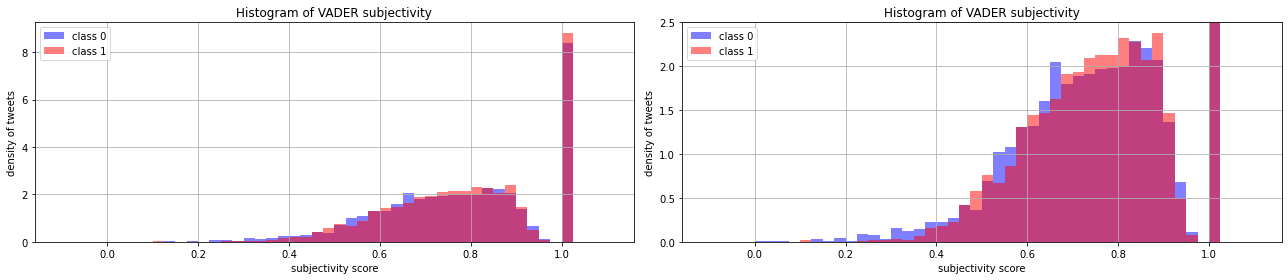

In [15]:
hide_code_in_slideshow()
plt.figure(figsize=(18, 4))

# Plot histograms of polarities
plt.subplot2grid((1, 2), (0, 0))
bins = np.arange(-0.1, 1.1, 0.025)
# TextBlob histogram
plt.title('Histogram of VADER subjectivity')
n, _, _ = plt.hist(subj_c0_vader, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(subj_c1_vader, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('subjectivity score')
plt.ylabel('density of tweets')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.subplot2grid((1, 2), (0, 1))
plt.title('Histogram of VADER subjectivity')
n, _, _ = plt.hist(subj_c0_vader, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(subj_c1_vader, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('subjectivity score')
plt.ylabel('density of tweets')
plt.ylim([0, 2.5])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# Meta-Level Features: Summary

In [16]:
!pip install tabulate

import pickle
from IPython.display import HTML
import tabulate
from sklearn import metrics

# Load individual feature performance metrics
with open('../reports/data/meta_features_individual.pck', 'rb') as f:
    eval_individual = pickle.load(f)

# Load union-features performance metrics
with open('../reports/data/meta_features_union.pck', 'rb') as f:
    eval_union = pickle.load(f)
    
# Compute chance performance metrics
y_pred_chance = np.random.randint(0, 2, size=len(y))
f1_chance = metrics.f1_score(y, y_pred_chance)
prec_chance = metrics.precision_score(y, y_pred_chance)
recall_chance = metrics.recall_score(y, y_pred_chance)
accuracy_chance = metrics.recall_score(y, y_pred_chance)


FileNotFoundError: [Errno 2] No such file or directory: '../reports/data/meta_features_individual.pck'

In [ ]:
hide_code_in_slideshow()

# Print table with performance delta to a chance classifier
table_header = ["Feature", "f1", "precision", "recall", "accuracy", "# features"]
table_data = [
    ['Chance', round(f1_chance, 2), round(prec_chance, 2), round(recall_chance, 2), 0]
]

# Add labels sorted by f1 score
for label, p in sorted(eval_individual.items(), key=lambda item: item[1]['F1'], reverse=True):
    table_data.append([
        label,
        '{} (Δ {}%)'.format(round((p['F1']), 2), round((p['F1']-f1_chance)*100, 2)),
        '{} (Δ {}%)'.format(round((p['Precision']), 2), round((p['Precision']-prec_chance)*100, 2)),
        '{} (Δ {}%)'.format(round((p['Recall']), 2), round((p['Recall']-recall_chance)*100, 2)),
        '{} (Δ {}%)'.format(round((p['Accuracy']), 2), round((p['Accuracy']-recall_chance)*100, 2)),
        len(eval_individual[label]['features'])
    ])
display.display(HTML(tabulate.tabulate(table_data, headers=table_header, tablefmt='html')))

In [ ]:
hide_code_in_slideshow()

# Print table with performance delta to a chance classifier
table_header = ["Feature", "f1", "precision", "recall", "accuracy", "# features"]
table_data = []
# Setup table data
for label, p in eval_union.items():
    table_data.append([
        label,
        '{}%'.format(round(p['F1']*100, 2)),
        '{}%'.format(round(p['Precision']*100, 2)),
        '{}%'.format(round(p['Recall']*100, 2)),
        '{}%'.format(round(p['Accuracy']*100, 2)),
        len(p['features'])
    ])
display.display(HTML(tabulate.tabulate(table_data, headers=table_header, tablefmt='html')))